# Comparison models to test the CatBoost against other models
Predictions of biomarkers and health outcomes using different ML methods. 

- 1.) ElasticNet
- 2.) XGBoost
- 3.)Transformers

In [117]:
### Using monkey_env/ ###

# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
import matplotlib.gridspec as gridspec
import math
import random

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost
from catboost import Pool

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

#fix the error that pops up about ipwydgets 
from tqdm import tqdm
#from .autonotebook import tqdm as notebook_tqdm

import warnings
warnings.filterwarnings("ignore")

print("Setup Complete")


Setup Complete


In [118]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [119]:
#Make a df for the blood analytic data
minbio_monkey_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    #date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
minbio_monkey_df.set_index(['ID'])
minbio_monkey_df['ID'] = minbio_monkey_df['ID'].astype(str)

#minbio_monkey_df.dropna(axis=0, inplace=True) 

minbio_monkey_df.columns
#minbio_monkey_df.tail()


Index(['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
      dtype='object')

In [120]:
# Make a df of a single monkey's blood analytic data
single_minbio_df = minbio_monkey_df.copy()
single_minbio_df = single_minbio_df[single_minbio_df['ID'] == '2046']
single_minbio_df.set_index(['ID'])
#single_minbio_df.reset_index()
single_minbio_df.head()


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,2017-11-02,Yes,2014-04-09,2007-07-03,F,Clinical,1303.0,43.0,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,2017-12-13,Yes,2014-04-09,2007-07-03,F,Clinical,1344.0,44.0,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386
35,2046,Rhesus-Chinese,2018-01-02,Yes,2014-04-09,2007-07-03,F,Research,1364.0,45.0,...,39.9,6.0,0.3,0.3,2140,1596,240,12,12,309
36,2046,Rhesus-Chinese,2018-01-31,Yes,2014-04-09,2007-07-03,F,Research,1393.0,46.0,...,46.8,5.6,0.5,0.0,2025,2012,241,22,0,275
37,2046,Rhesus-Chinese,2018-04-05,Yes,2014-04-09,2007-07-03,F,Research,1457.0,48.0,...,22.8,5.8,0.1,0.1,6123,1961,499,9,9,325


In [121]:
#Makee a df were there is one monkey's data missing (the same in the single_monkey_df)
oneless_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    #date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
oneless_df.set_index(['ID'])

oneless_df['ID'] = oneless_df['ID'].astype(str)

#oneless_dff.dropna(axis=0, inplace=True) 

#oneless_df.columns
oneless_df.tail()

,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4529,2112,Rhesus-Chinese,2020-09-23 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,67.0,6.2,1.1,0.0,1696,4422,409,73,0,289
4530,2112,Rhesus-Chinese,2021-03-04 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,56.1,9.1,1.5,0.0,1312,2210,359,59,0,284
4531,2210,Rhesus-Indian,2021-09-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,26.8,12.3,1.2,0.0,3104,1394,640,62,0,311
4532,2210,Rhesus-Indian,2021-09-20 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4533,2210,Rhesus-Indian,2021-10-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


# ElasticNet
- All inputs have to be numeric
- Can't handle NaN


In [8]:
# evaluate an elastic net model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet

## ElasticNet Piepline

In [22]:
### automote elasticnet data setup

def elnet_data_setup (df): 
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    global X, y, ylabel
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #put data into pool
    global pool
    pool = Pool(data=X, label=y)
    
    #train tesr split - 30% test
    test_size = 0.3
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    global  X_train, X_validation, y_train, y_validation
    X_train, X_validation, y_train, y_validation= data
    
    global train_pool
    train_pool = Pool(
        data = X_train,
        label = y_train,
    )
    
    global validation_pool
    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
    )


In [23]:
### automate prediction and plotting for elasticnet

def elnet_predict_and_plot(model, X_validation, y_validation, y):
    
    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)
    
    ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df, c='r')

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    plot_title = input("Plot Title:") 
    ax.set_title(plot_title
                 ,fontsize=15
    )
   
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    
    #Save the plot
    fig_name = input('Figure name')
    plt.savefig("%s.pdf" % fig_name, dpi=900, bbox_inches='tight')
    

In [24]:
### automote elasticnet from data setup to plotting, very similar to catboost

def elnet_pipeline (df):
    elnet_data_setup(df)
    
    model = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model.fit(X_train, y_train)
    
    elnet_predict_and_plot(model, X_validation, y_validation, y)
    

## ElasticNet Cycler

In [101]:
### prediction and plotter for the elasticnet cycler

def elnet_cycler_pred_plotter (model, X_validation, y_validation, y):
        
    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)
    
    ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df, c='r')

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    ax.set_title(ylabel,
                 fontsize=15
    )
   
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    


In [102]:
### Elasticnet cycler to go through all the biomakrers

def elnet_cycler (df):
    
    avoid_list = ['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']
    
    for (columnName, columnData) in df.iteritems():
        if columnName in    avoid_list:
            continue
        else:     
            ### Data Setup ###

            (train_df, test_df)= df, df 

            #data labeling
            global ylabel
            ylabel = columnName
            y = df[ylabel]
            X = df.drop(['ID',ylabel],axis=1)


            #put data into pool
            global pool
            pool = Pool(data=X, label=y)

            #train tesr split
            #test_size = float(input('Test Size'))
            global data
            test_size = 0.3
            data= train_test_split(X, y, test_size=test_size, random_state=0)

            #The order of this matters#
            global  X_train, X_validation, y_train, y_validation
            X_train, X_validation, y_train, y_validation= data

            global train_pool
            train_pool = Pool(
                data = X_train,
                label = y_train
            )

            global validation_pool
            validation_pool = Pool(
                data = X_validation,
                label = y_validation
            )

            global model
            model = ElasticNet(alpha=1.0, l1_ratio=0.5)
            model.fit(X_train, y_train)

            elnet_cycler_pred_plotter (model, X_validation, y_validation, y)

## Multi Monkey Predictions

In [15]:
#count control monkeys
print('Non-Irradiated Samples:{}'.format(minbio_monkey_df['IRRAD'].value_counts()['No']))
 
# Count the irradiated monkeys
print('Irradiated Samples:{}'.format(minbio_monkey_df['IRRAD'].value_counts()['Yes']))

#Count Males
print('Males:{}'.format(minbio_monkey_df['SEX'].value_counts()['M']))
 
# Count females
print('Females:{}'.format(minbio_monkey_df['SEX'].value_counts()['F']))


Non-Irradiated Samples:970
Irradiated Samples:3582
Males:3608
Females:944


In [16]:
#make a parent df
minbio_monkey_df.copy()
elnet_df = minbio_monkey_df

#Exclude datetime and catagorical feautres
elnet_df=elnet_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
elnet_df['SEX'] = elnet_df['SEX'].map({'M':1, 'F': 0})
elnet_df['IRRAD'] = elnet_df['IRRAD'].map({'Yes':1, 'No': 0})


# Take care of NaN
elnet_df['DOSE_(Gy)'] = elnet_df['DOSE_(Gy)'].fillna(0)
elnet_df['DAYS_SINCE_IRRAD'] = elnet_df['DAYS_SINCE_IRRAD'].fillna(0)
elnet_df['MONTHS_SINCE_IRRAD'] = elnet_df['MONTHS_SINCE_IRRAD'].fillna(0)
elnet_df['MONTHS AT IRRAD'] = elnet_df['MONTHS AT IRRAD'].fillna(0)

elnet_df.head(5)

,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,WBC_(K/uL),RBC_(M/uL),...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,0,0,0.0,0.0,0.0,0.0,10.6,10.9,5.05,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,0,0,0.0,0.0,0.0,0.0,10.7,8.8,4.59,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334
2,2061,0,0,0.0,0.0,0.0,0.0,10.9,17.5,4.74,...,8.5,3.4,0.1,0.1,15383,1488,595,18,18,321
3,2061,0,0,0.0,0.0,0.0,0.0,11.3,21.1,4.76,...,5.5,2.7,0.1,0.0,19349,1161,570,21,0,310
4,2061,0,0,0.0,0.0,0.0,0.0,11.6,11.5,4.53,...,14.5,6.6,0.1,0.0,9062,1668,759,12,0,486


In [17]:
#count control monkeys
print('Non-Irradiated Samples:{}'.format(elnet_df['IRRAD'].value_counts()[0]))
 
# Count the irradiated monkeys
print('Irradiated Samples:{}'.format(elnet_df['IRRAD'].value_counts()[1]))

#Count Males
print('Males:{}'.format(elnet_df['SEX'].value_counts()[1]))
 
# Count females
print('Females:{}'.format(elnet_df['SEX'].value_counts()[0]))

Non-Irradiated Samples:970
Irradiated Samples:3582
Males:3608
Females:944


Target Feature Column: LYMPHOCYTES_(%)
Plot Title: Multi Monkey Lymphocytes
Figure name elnet-mulit-lymph


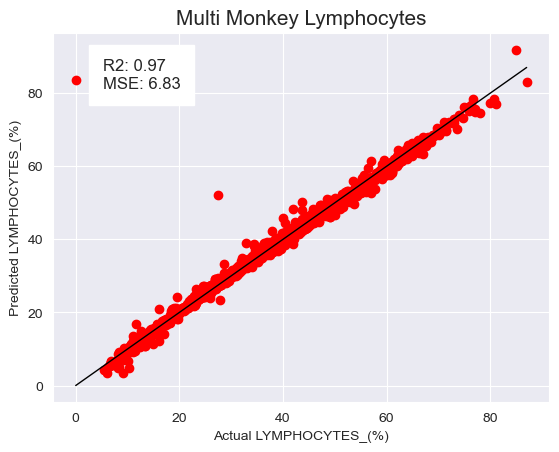

In [103]:
# Multi Monkey Lymphocyte Predictions with NaN converted to 0
elnet_pipeline(elnet_df)

### Without NaN converted to 0

In [53]:
#make a parent df
minbio_monkey_df.copy()
no_df = minbio_monkey_df

#Exclude datetime and catagorical feautres
no_df=no_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE','DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
no_df['SEX'] = no_df['SEX'].map({'M':1, 'F': 0})
no_df['IRRAD'] = no_df['IRRAD'].map({'Yes':1, 'No': 0})
no_df['DOSE_(Gy)'] = no_df['DOSE_(Gy)'].fillna(0)

no_df.head(2)

,ID,IRRAD,SEX,DOSE_(Gy),AGE,WBC_(K/uL),RBC_(M/uL),Hemaglobin_(HGB_g/dL),Hemocrit_(HCT_%),Mean_corpuscular_volume_(MCV_fL),...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,0,0,0.0,10.6,10.9,5.05,12.0,35.7,70.69,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,0,0,0.0,10.7,8.8,4.59,10.5,33.3,72.55,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


Target Feature Column: LYMPHOCYTES_(%)
Plot Title: Multi Monkey Lymphocytes
Figure name elnet-multi


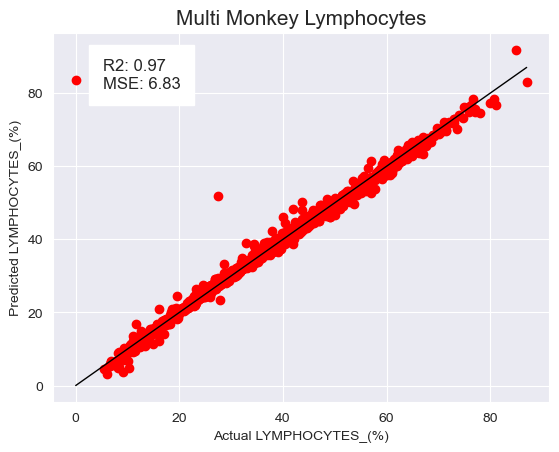

In [54]:
# Multi Monkey Lymphocytes Wihtout NaN converted to 0
elnet_pipeline(no_df)

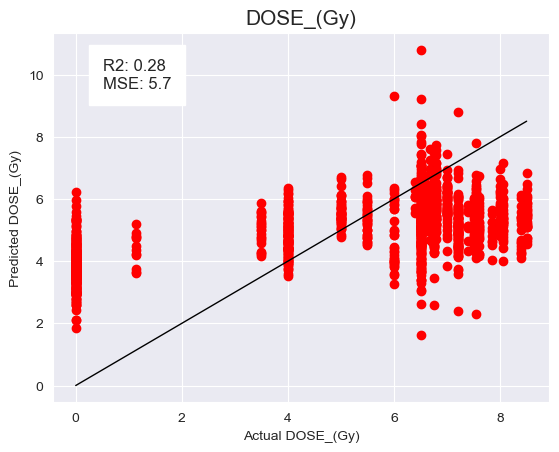

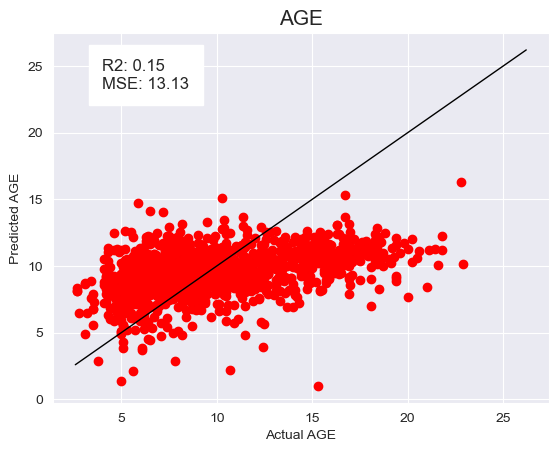

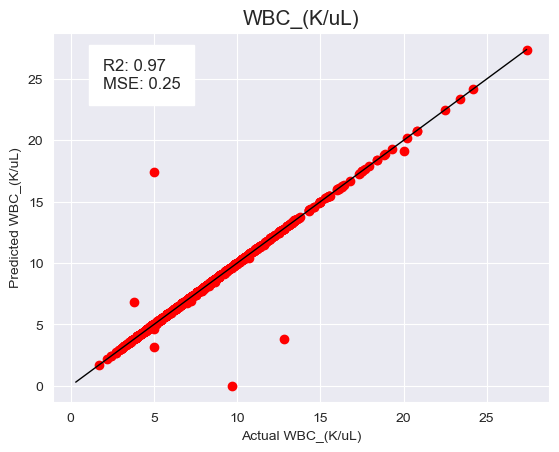

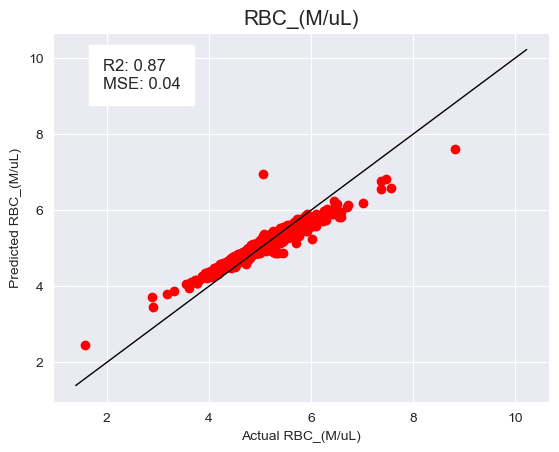

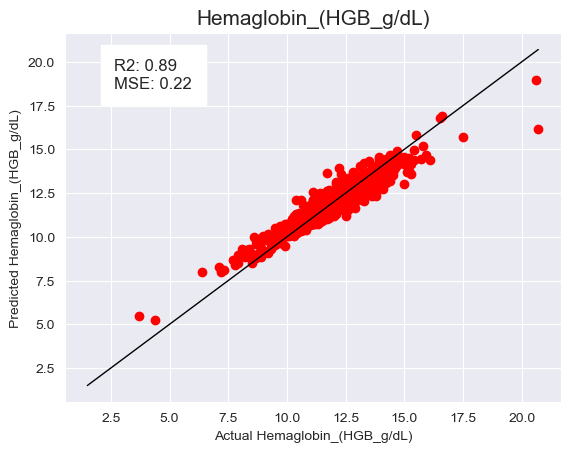

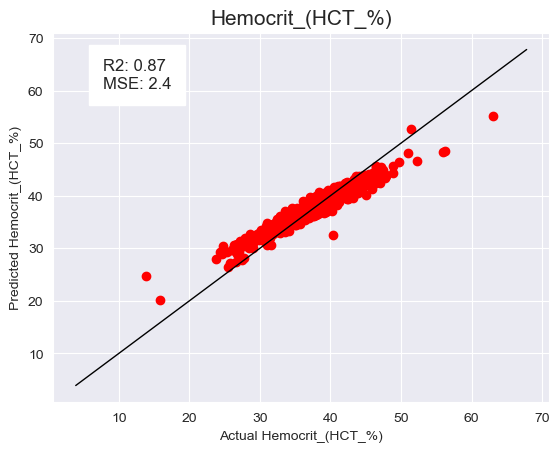

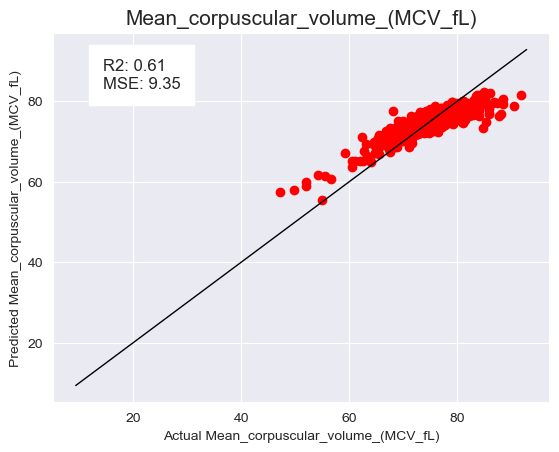

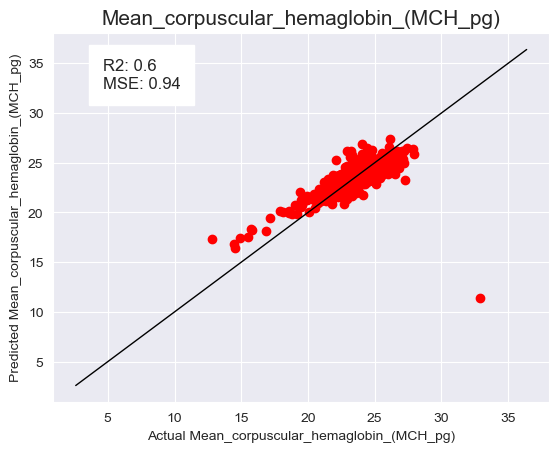

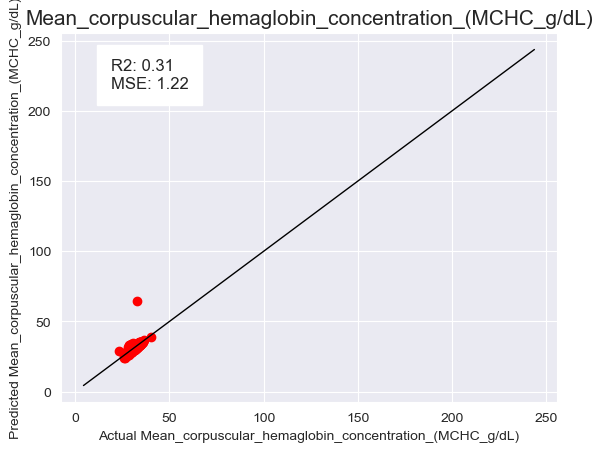

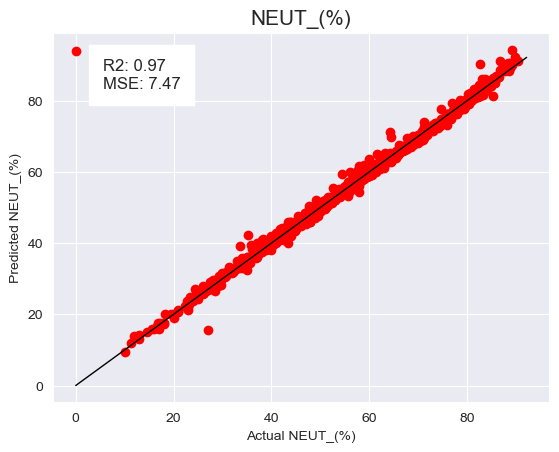

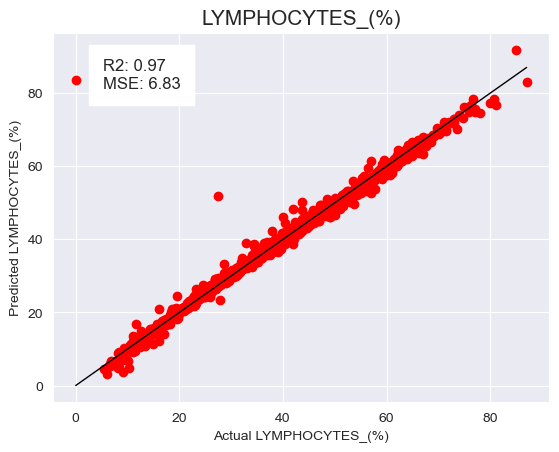

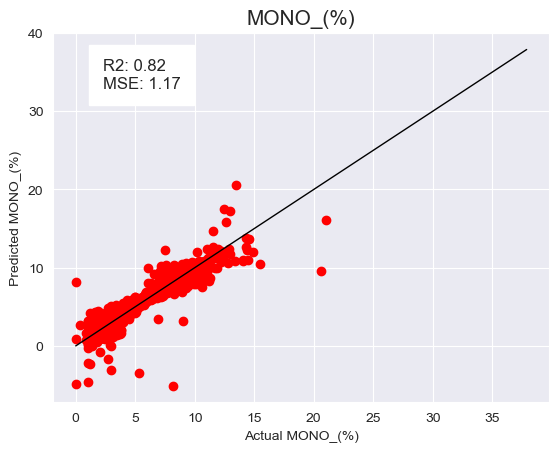

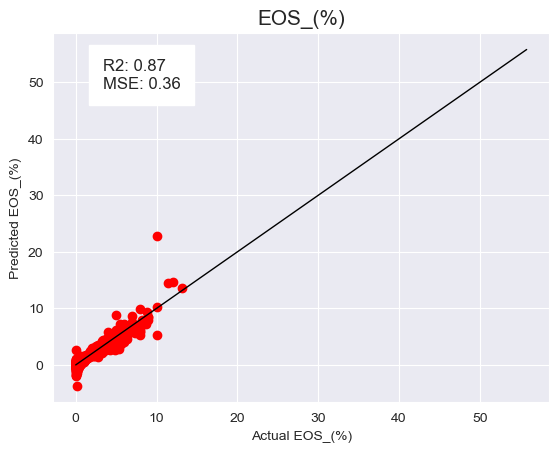

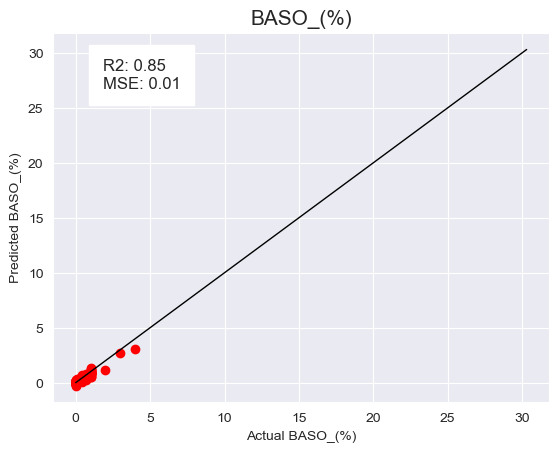

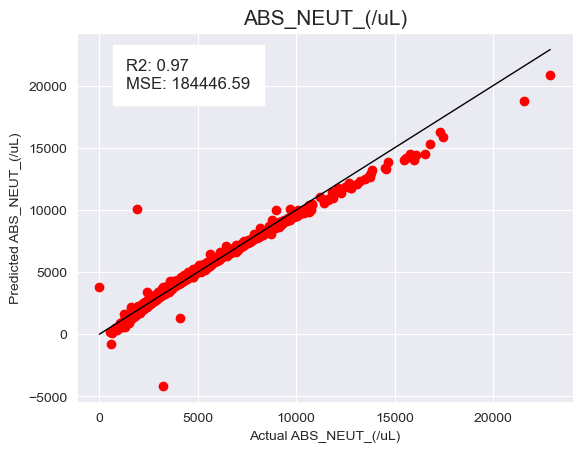

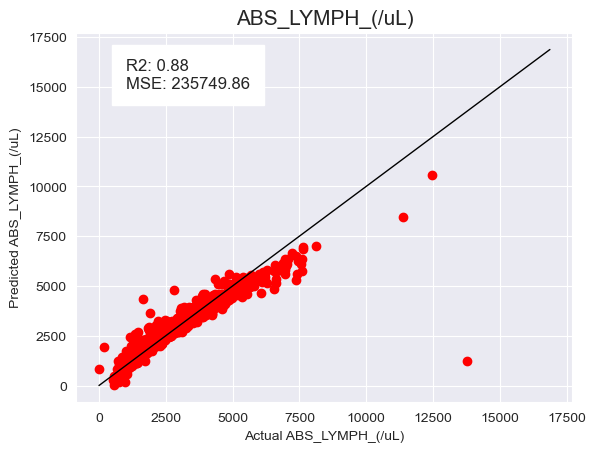

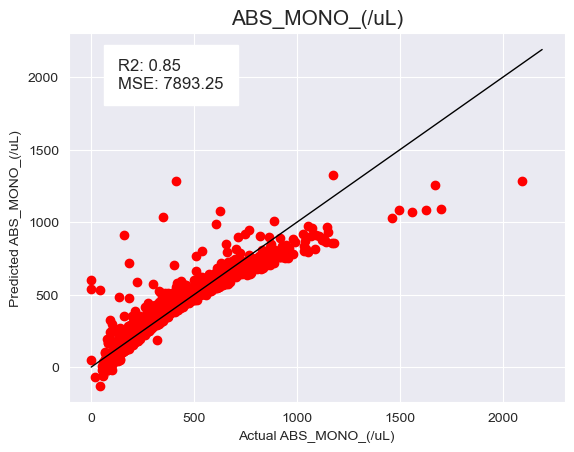

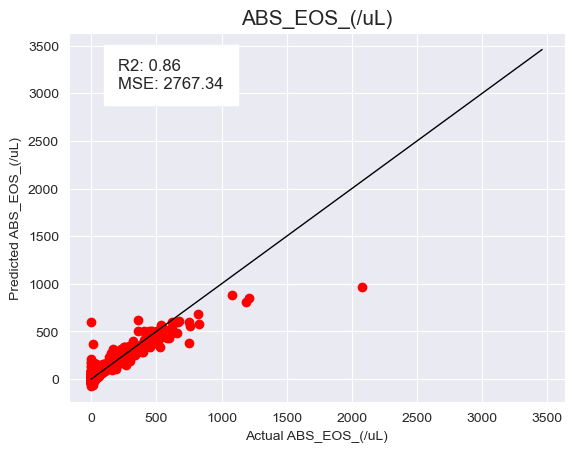

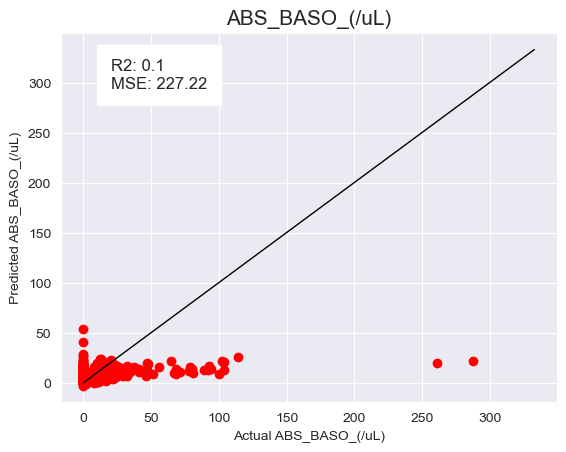

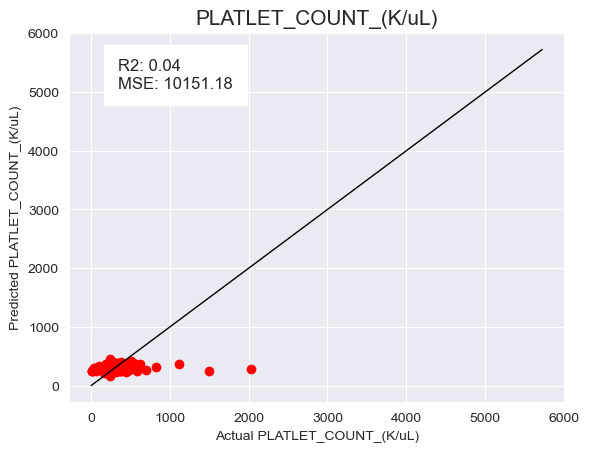

In [104]:
# Make all biomaker predictions with ElasticNet
elnet_cycler(no_df) 

## Predicting single monkey biomarkers w/multi monkey data

In [152]:
#make a parent df for the single monkey data
single_minbio_df.copy()
single_df=single_minbio_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE','DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
single_df['SEX'] = single_df['SEX'].map({'M':1, 'F': 0})
single_df['IRRAD'] = single_df['IRRAD'].map({'Yes':1, 'No': 0})
single_df['DOSE_(Gy)'] = single_df['DOSE_(Gy)'].fillna(0)

#single_minbio_df.head(2)
single_df.head(2)

,ID,IRRAD,SEX,DOSE_(Gy),AGE,WBC_(K/uL),RBC_(M/uL),Hemaglobin_(HGB_g/dL),Hemocrit_(HCT_%),Mean_corpuscular_volume_(MCV_fL),...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,1,0,1.14,10.3,3.8,6.08,14.2,41.6,68.42,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,1,0,1.14,10.4,7.0,5.38,12.2,36.2,67.29,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386


In [153]:
# make a df for the mulit monkey df without 2046
oneless_df.copy()
ol_df = oneless_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE','DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
ol_df['SEX'] = ol_df['SEX'].map({'M':1, 'F': 0})
ol_df['IRRAD'] = ol_df['IRRAD'].map({'Yes':1, 'No': 0})
ol_df['DOSE_(Gy)'] = ol_df['DOSE_(Gy)'].fillna(0)

ol_df.head(2)


,ID,IRRAD,SEX,DOSE_(Gy),AGE,WBC_(K/uL),RBC_(M/uL),Hemaglobin_(HGB_g/dL),Hemocrit_(HCT_%),Mean_corpuscular_volume_(MCV_fL),...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,0,0,0.0,10.6,10.9,5.05,12.0,35.7,70.69,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,0,0,0.0,10.7,8.8,4.59,10.5,33.3,72.55,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


In [154]:
# Split the dfs

# multi monkey data split
mul_y=ol_df['LYMPHOCYTES_(%)']
mul_X=ol_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

mul_data= train_test_split(mul_X, mul_y, test_size=0.3, random_state=0)
mul_X_train, mul_X_validation, mul_y_train, mul_y_validation= mul_data

mul_train_pool = Pool(
    data = mul_X_train,
    label = mul_y_train
)


mul_validation_pool = Pool(
    data = mul_X_validation,
    label = mul_y_validation,
)


# single monkey data split
sin_y=single_df['LYMPHOCYTES_(%)']
sin_X=single_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

sin_data= train_test_split(sin_X, sin_y, test_size=0.3, random_state=0)
sin_X_train, sin_X_validation, sin_y_train, sin_y_validation= sin_data

sin_train_pool = Pool(
    data = sin_X_train,
    label = sin_y_train
)


sin_validation_pool = Pool(
    data = sin_X_validation,
    label = sin_y_validation,
)





In [155]:
# define model
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# fit model
model.fit(mul_X_train, mul_y_train)

ElasticNet()

Plot Title: Single Monkey Predictions with Multi Monkey Data


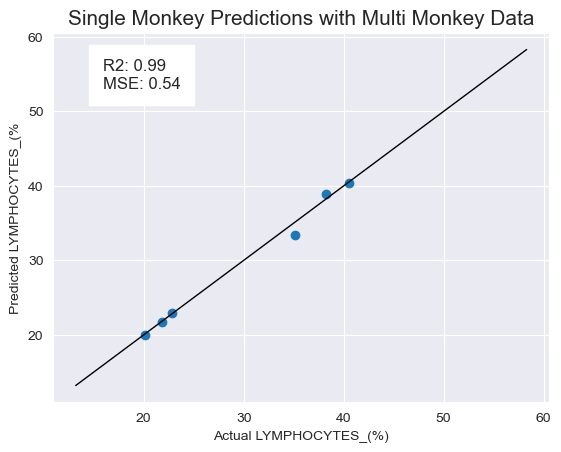

In [127]:
# make a prediction
a = model.predict(sin_X_validation)
a_df = pd.DataFrame(a)


### Plotting ###
# Plot the predictions
fig, ax = plt.subplots()
ax.scatter(sin_y_validation, a_df, c='r')

ax.plot([sin_y.min(), sin_y.max()], [sin_y.min(), sin_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

#Plot axis titles
ax.set_xlabel('Actual LYMPHOCYTES_(%)')
ax.set_ylabel('Predicted LYMPHOCYTES_(%')

#Title of the plot
plot_title = input("Plot Title:")
#show_iters = model.get_param('iterations')  
ax.set_title(plot_title #+ "\nIterations: {}".format(str(show_iters))
             ,fontsize=15
)

#cordinates for the R2 value box
xmin, xmax, ymin, ymax = plt.axis()
yrange = ymax-ymin
xrange = xmax-xmin


#Plotting the R2 score and MSE
ax.annotate("R2: {}".format(str(r2_score(sin_y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(sin_y_validation, a_df).round(2))),
            xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
            fontsize=12,
            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
)


plt.show() 


Plot Title: Single Monkey Predictions with Multi Monkey Data
Figure name elnet-sm-lymph


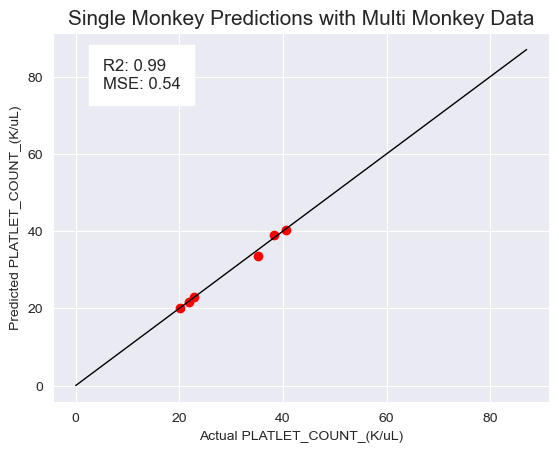

In [128]:
# Single Monkey Predictions with Multi Monkey Data
elnet_predict_and_plot(model, sin_X_validation, sin_y_validation, y)

## Dose Predictions

Target Feature Column: DOSE_(Gy)
Plot Title: Multi Monkey Dose (Gy) Predictions
Figure name elnet-dose


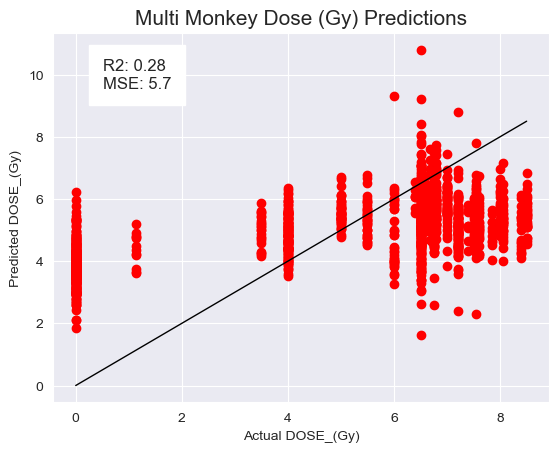

In [151]:
# Multi Monkey Dose (Gy)
elnet_pipeline(no_df)

## Using top 5 features

Single Monkey:
Top 5 features:
- 0	NEUT_(%)	25.791263
- 1	TYPE	13.162456
- 2	ABS_LYMPH_(/uL)	13.094777
- 3	EOS_(%)	11.994731
- 4	RBC_(M/uL)	11.799281
- 5	Hemocrit_(HCT_%)	4.794531
- 6	Mean_corpuscular_hemaglobin_concentration_(MCH...	4.392843

- Use non-lymphocyte related features: independence


Multi Monkey:
Top 5 features:
- 0	NEUT_(%)	86.690265
- 1	ABS_LYMPH_(/uL)	4.309505
- 2	ABS_MONO_(/uL)	2.908496
- 3	MONO_(%)	2.536824
- 4	EOS_(%)	1.749061
- 5	ABS_EOS_(/uL)	0.948118
- 6	Hemaglobin_(HGB_g/dL)	0.429481

- Use non-lymphocyte related features: independence



In [146]:
### Make the reduced df

#make a parent df
### Used the 6th (hemocrit) 
single_minbio_df.copy()
sred_reg_df = single_minbio_df[['ID', 'NEUT_(%)', #'ABS_LYMPH_(/uL)',
                                'EOS_(%)','RBC_(M/uL)', 'Hemocrit_(HCT_%)', 'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)',
                                'LYMPHOCYTES_(%)']]
sred_reg_df.tail(2)


,ID,NEUT_(%),EOS_(%),RBC_(M/uL),Hemocrit_(HCT_%),Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL),LYMPHOCYTES_(%)
49,2046,36.9,0.2,6.55,43.0,32.79,58.3
50,2046,45.9,0.3,5.56,39.4,31.22,52.8


Target Feature Column: LYMPHOCYTES_(%)
Plot Title: Predicting Single Monkey Lymphocyte Using 5 Features
Figure name elneet-single-5


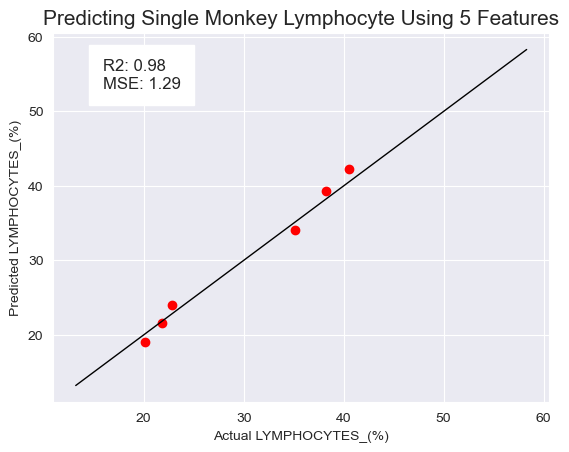

In [147]:
# Predicting Sinlge Monkey Lymphocyte Using 5 Features
elnet_pipeline(sred_reg_df)

In [140]:
### Make the reduced df

#make a parent df
minbio_monkey_df.copy()
mred_reg_df = minbio_monkey_df[['ID', 'NEUT_(%)', 'ABS_MONO_(/uL)', 'MONO_(%)', #'ABS_LYMPH_(/uL)',
                                'EOS_(%)','Hemaglobin_(HGB_g/dL)', 'LYMPHOCYTES_(%)']]


#mred_reg_df.tail(2)
sred_reg_df.tail(2)

,ID,Hemaglobin_(HGB_g/dL),NEUT_(%),ABS_LYMPH_(/uL),EOS_(%),RBC_(M/uL),LYMPHOCYTES_(%)
49,2046,14.1,36.9,5130,0.2,6.55,58.3
50,2046,12.3,45.9,3897,0.3,5.56,52.8


Target Feature Column: LYMPHOCYTES_(%)
Plot Title: Predicting Mulit Monkey Lymphocyte Using 5 Features
Figure name elnet-multi-5


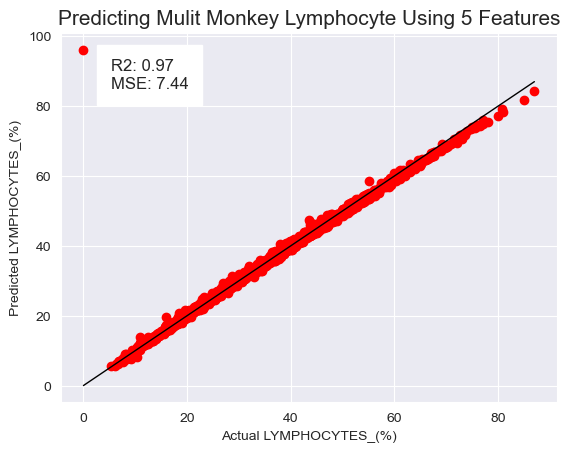

In [141]:
# Predicting Multi Monkey Lymphocyte Using 5 Features
elnet_pipeline(mred_reg_df)

## Using Irrad data

In [74]:
### Make the irrad only df

#make a parent df
minbio_monkey_df.copy()
mrad_df = minbio_monkey_df[['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'LYMPHOCYTES_(%)']]
mrad_df.head(5)

minbio_monkey_df.head(5)


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,Rhesus-Chinese,2017-12-20,NaN,NaT,2007-05-14,NaN,Clinical,NaN,NaN,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,Rhesus-Chinese,2018-01-29,NaN,NaT,2007-05-14,NaN,Research,NaN,NaN,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334
2,2061,Rhesus-Chinese,2018-04-04,NaN,NaT,2007-05-14,NaN,Research,NaN,NaN,...,8.5,3.4,0.1,0.1,15383,1488,595,18,18,321
3,2061,Rhesus-Chinese,2018-08-17,NaN,NaT,2007-05-14,NaN,Research,NaN,NaN,...,5.5,2.7,0.1,0.0,19349,1161,570,21,0,310
4,2061,Rhesus-Chinese,2018-12-05,NaN,NaT,2007-05-14,NaN,Research,NaN,NaN,...,14.5,6.6,0.1,0.0,9062,1668,759,12,0,486


In [77]:
### Make the irrad only df

#make a parent df
elnet_df.copy()
mrad_df = elnet_df[['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'LYMPHOCYTES_(%)']]

mrad_df.tail(2)


,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,LYMPHOCYTES_(%)
4550,2210,0,0,0.0,0.0,0.0,0.0,25.5,36.2
4551,2210,0,0,0.0,0.0,0.0,0.0,22.8,16.0


Target Feature Column: LYMPHOCYTES_(%)
Plot Title: Lymphocyte Predictions Using Radiation Data
Figure name elnet-multi-irrad


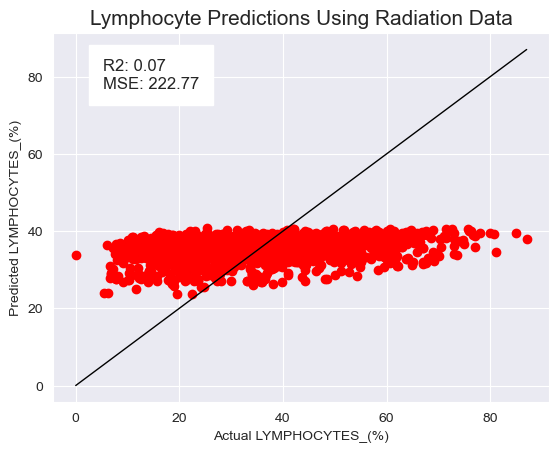

In [78]:
# Lymphocyte Predictions Using Radiation Data
elnet_pipeline(mrad_df)

# XGBoost
- No catagorical
- Needs a lot of tuning

In [79]:
import xgboost as xgb
from xgboost import XGBRegressor

## XGBoost Pipeline

In [80]:
### automote xgb data setup

def xgb_data_setup (df):
    
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    global X, y, ylabel
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #put data into pool
    global pool
    pool = Pool(data=X, label=y)
    
    #train tesr split - 30% test
    test_size = 0.3
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    global  X_train, X_validation, y_train, y_validation
    X_train, X_validation, y_train, y_validation= data
    
    global train_pool
    train_pool = Pool(
        data = X_train,
        label = y_train,
    )
    
    global validation_pool
    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
    )


In [81]:
### automate prediction and plotting for xgb

def xgb_predict_and_plot(model, X_validation, y_validation, y):
    
    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)
    
    ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df, c='m')

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    plot_title = input("Plot Title:") 
    ax.set_title(plot_title
                 ,fontsize=15
    )
   
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
   
    #Save the plot
    fig_name = input('Figure name')
    plt.savefig("%s.pdf" % fig_name, dpi=900, bbox_inches='tight')
    
    

In [82]:
### automote elasticnet from data setup to plotting, very similar to catboost

def xgb_pipeline (df):
    
    xgb_data_setup (df)
    
    model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10)
    model.fit(X_train, y_train)
    
    xgb_predict_and_plot(model, X_validation, y_validation, y)

## XGBoost Cycler

In [83]:
### prediction and plotter for the xgb cycler

def xgb_cycler_pred_plotter (model, X_validation, y_validation, y):
        
    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)
    
    ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df, c='m')

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    ax.set_title(ylabel,
                 fontsize=15
    )
   
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    


In [84]:
### Elasticnet cycler to go through all the biomakrers

def xgb_cylcer (df):
        
    avoid_list = ['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']
    
    for (columnName, columnData) in df.iteritems():
        if columnName in    avoid_list:
            continue
        else:     
            ### Data Setup ###

            (train_df, test_df)= df, df 

            #data labeling
            global ylabel
            ylabel = columnName
            y = df[ylabel]
            X = df.drop(['ID',ylabel],axis=1)


            #put data into pool
            global pool
            pool = Pool(data=X, label=y)

            #train tesr split
            #test_size = float(input('Test Size'))
            global data
            test_size = 0.3
            data= train_test_split(X, y, test_size=test_size, random_state=0)

            #The order of this matters#
            global  X_train, X_validation, y_train, y_validation
            X_train, X_validation, y_train, y_validation= data

            global train_pool
            train_pool = Pool(
                data = X_train,
                label = y_train
            )

            global validation_pool
            validation_pool = Pool(
                data = X_validation,
                label = y_validation
            )

            global model
            model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10)
            model.fit(X_train, y_train)

            xgb_cycler_pred_plotter (model, X_validation, y_validation, y)

## XGBoost Classifier 

In [158]:
# pipleline for xgb classifieer - data setup to plotting
def xgb_classifier_pipeline (df):
    xgb_data_setup (df)
    
    model = xgb.XGBClassifier(objective='binary:logistic',
                  n_estimators = 10, seed = 123)
  
    # Fitting the model
    model.fit(X_train, y_train)
    
    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)

    ### Plotting ###
    # make confusion matrix
    cm = confusion_matrix(y_validation, a_df)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  #display_labels=clf.classes_
                                 )
    disp.plot()
    plt.grid(False)


    Accuracy = metrics.accuracy_score(y_validation, a_df)
    Precision = metrics.precision_score(y_validation, a_df)

    
    #Save the plot
    fig_name = input('Figure name')
    plt.savefig("%s.pdf" % fig_name, dpi=900, bbox_inches='tight')

    
    print('Accuracy:',Accuracy, 'Precision:',Precision)
    print(classification_report(y_validation, a_df))

In [90]:
#make a parent df
elnet_df.copy()
xg_df = elnet_df

#Exclude datetime and catagorical feautres
#xg_df=xg_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE','DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD'],axis=1)

xg_df.head(2)

,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,WBC_(K/uL),RBC_(M/uL),...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,0,0,0.0,0.0,0.0,0.0,10.6,10.9,5.05,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,0,0,0.0,0.0,0.0,0.0,10.7,8.8,4.59,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


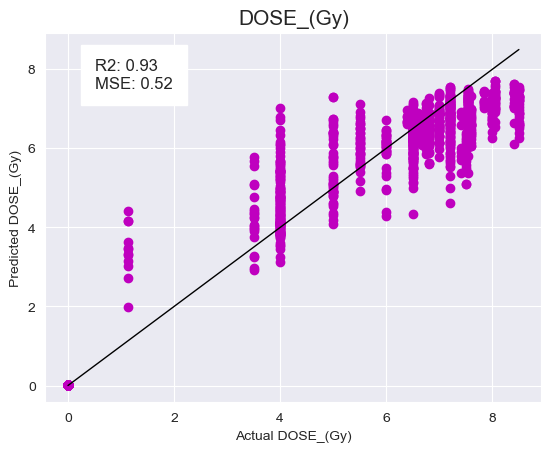

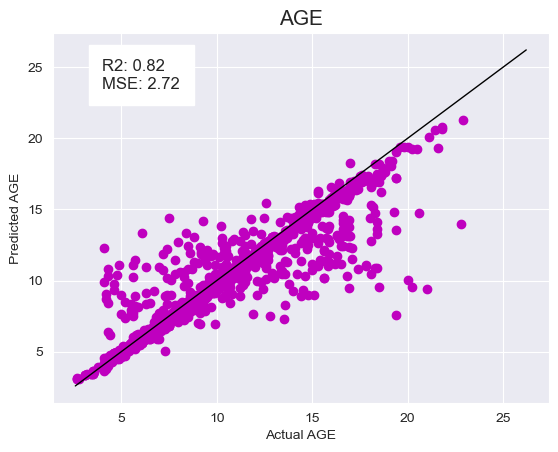

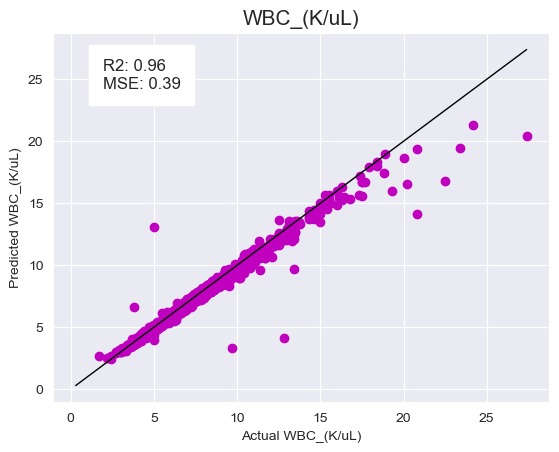

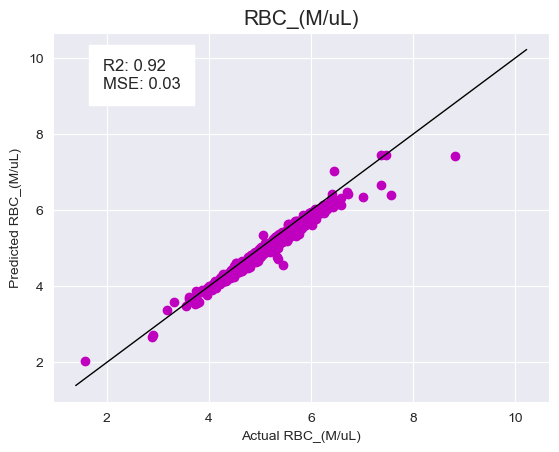

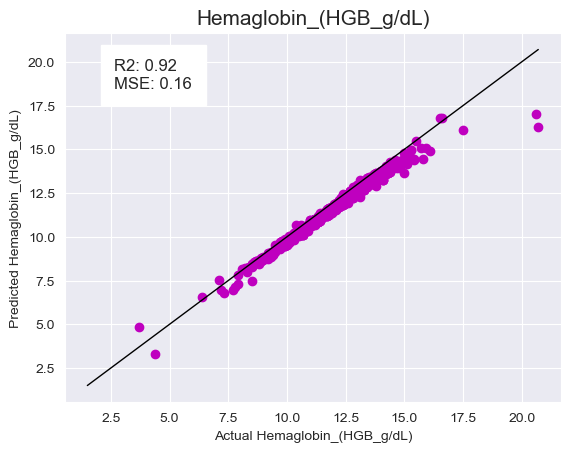

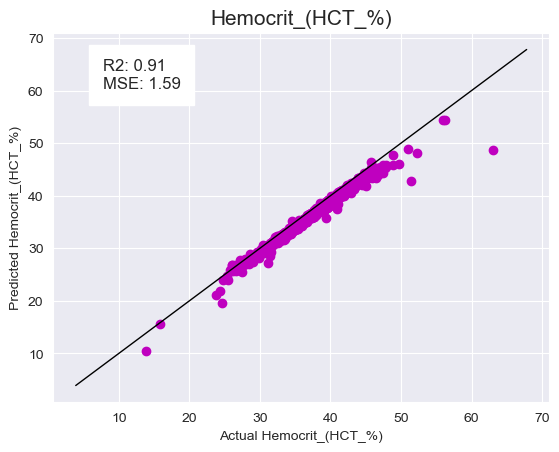

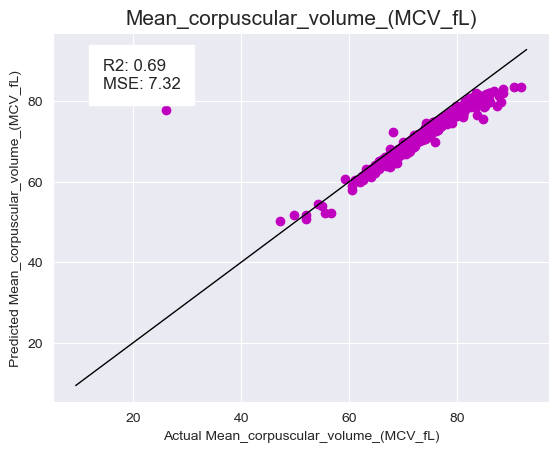

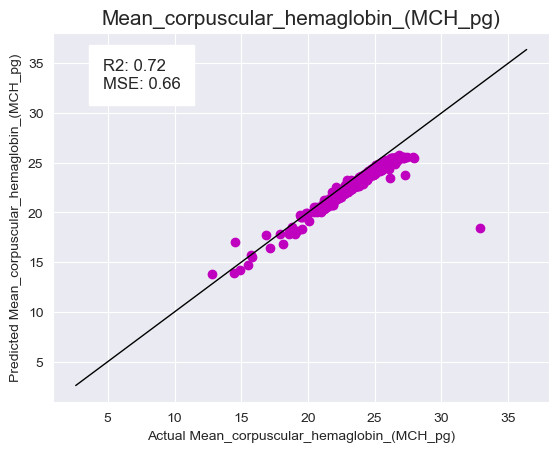

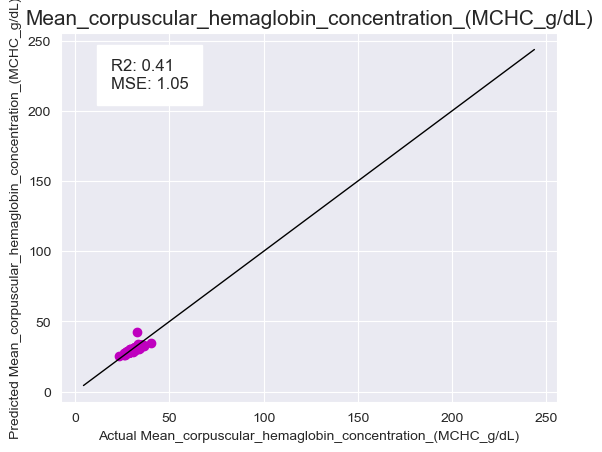

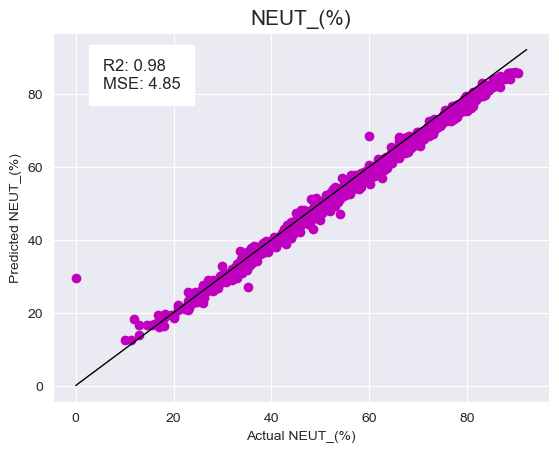

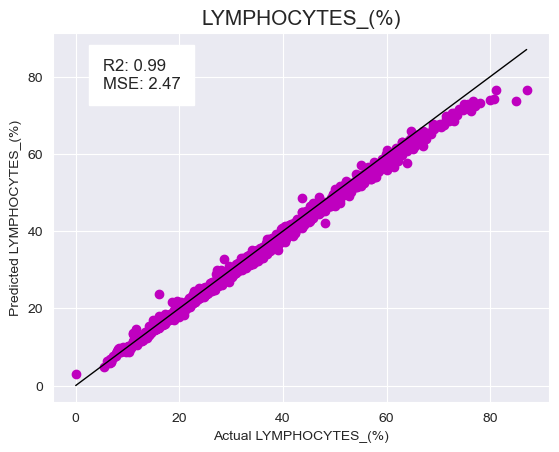

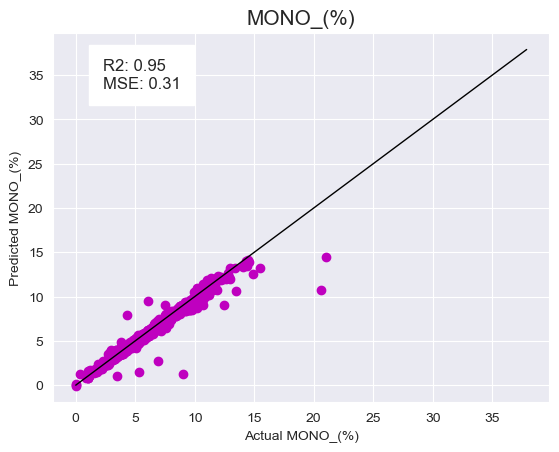

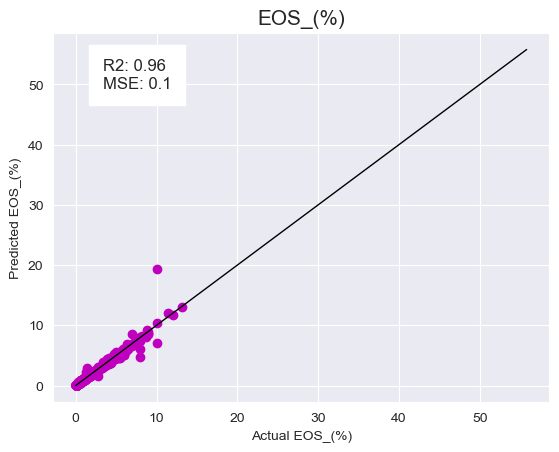

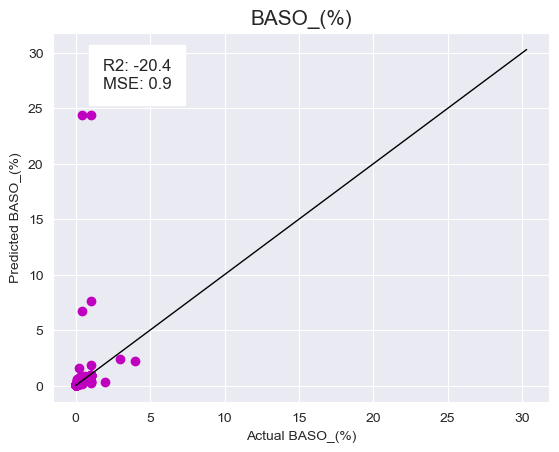

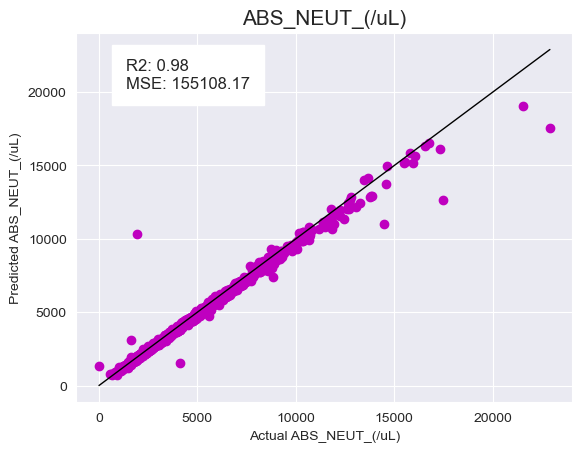

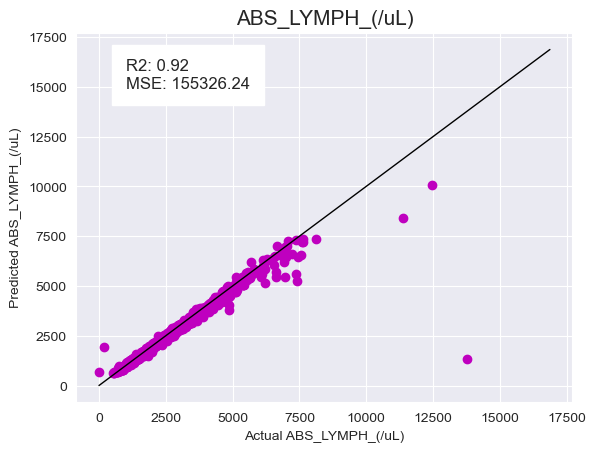

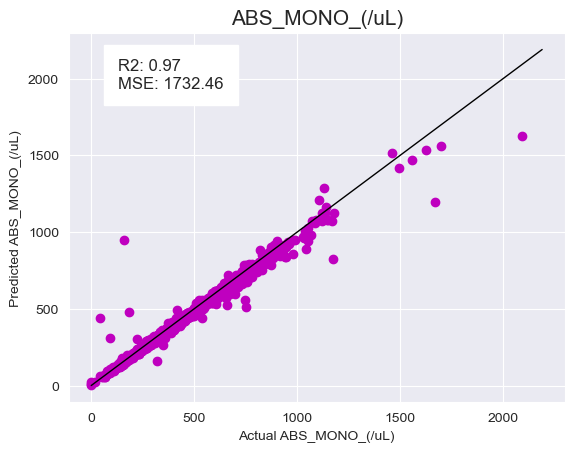

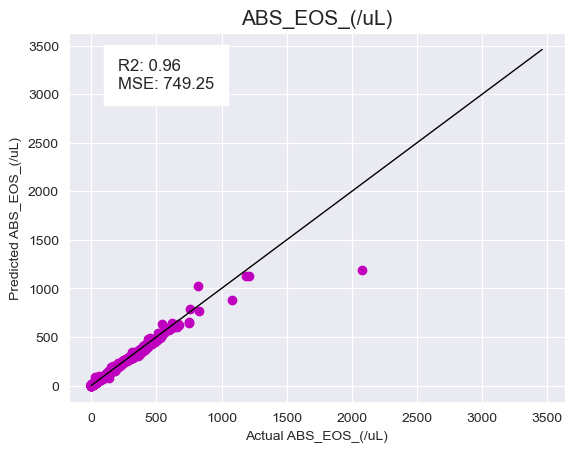

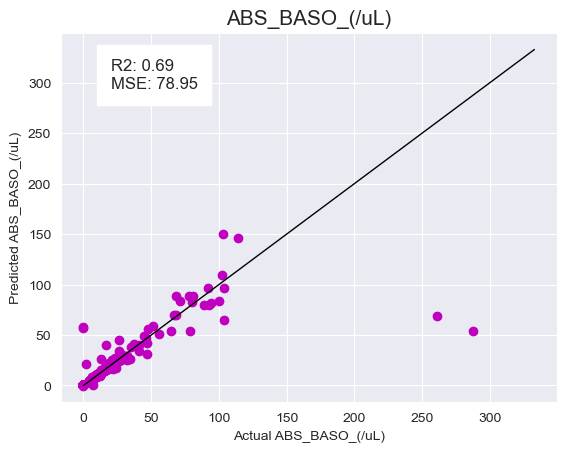

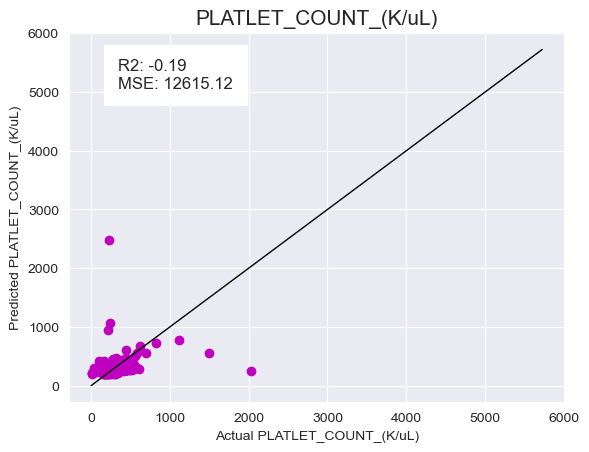

In [97]:
#predict all biomarkers
xgb_cylcer (xg_df)

## Multi Monkey Predictions

Target Feature Column: LYMPHOCYTES_(%)
Plot Title: Multi Monkey Lymphocytes
Figure name xgb-lymph


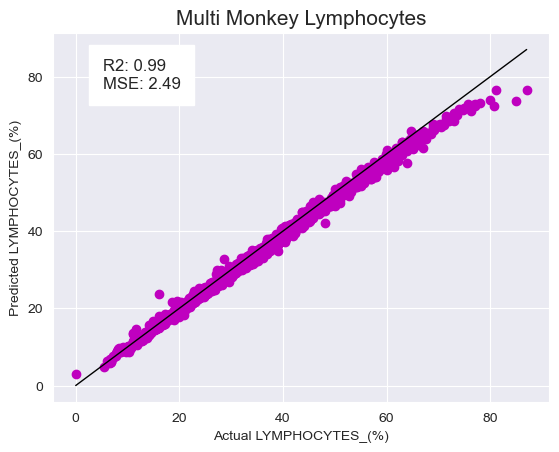

In [61]:
# Multi Monkey Lymphocyte Predictions
xgb_pipeline (xg_df)

## Predicting Single monkey biomarkers w/ multi monkey data`

In [136]:
# make a df for the multi monkey data
oneless_df.copy()
xg_ol_df = oneless_df

#Exclude datetime and catagorical feautres
xg_ol_df = xg_ol_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
xg_ol_df['SEX'] = xg_ol_df['SEX'].map({'M':1, 'F': 0})
xg_ol_df['IRRAD'] = xg_ol_df['IRRAD'].map({'Yes':1, 'No': 0})


# Take care of NaN
xg_ol_df['DOSE_(Gy)'] =xg_ol_df['DOSE_(Gy)'].fillna(0)

xg_ol_df.head(2)

,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,WBC_(K/uL),RBC_(M/uL),...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,0,0,NaN,NaN,NaN,0.0,10.6,10.9,5.05,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,0,0,NaN,NaN,NaN,0.0,10.7,8.8,4.59,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


In [49]:
#make a parent df

minbio_monkey_df.copy()
mul_xg_df = minbio_monkey_df

#Exclude datetime and catagorical feautres
mul_xg_df=mul_xg_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
mul_xg_df['SEX'] = mul_xg_df['SEX'].map({'M':1, 'F': 0})
mul_xg_df['IRRAD'] = mul_xg_df['IRRAD'].map({'Yes':1, 'No': 0})


# Take care of NaN
mul_xg_df['DOSE_(Gy)'] = mul_xg_df['DOSE_(Gy)'].fillna(0)

In [131]:
#make a df for the single monkey data

single_minbio_df.copy()
sin_xg_df = single_minbio_df

#Exclude datetime and catagorical feautres
sin_xg_df=sin_xg_df.drop(['Species','IRRAD_DATE','DOB','SAMPLE_DATE','TYPE'],axis=1)

#convert irrad(yes=1, no=0) and sex (male=1, female=0) to binary 
sin_xg_df['SEX'] = sin_xg_df['SEX'].map({'M':1, 'F': 0})
sin_xg_df['IRRAD'] = sin_xg_df['IRRAD'].map({'Yes':1, 'No': 0})


# Take care of NaN
sin_xg_df['DOSE_(Gy)'] = sin_xg_df['DOSE_(Gy)'].fillna(0)


In [137]:
###Train/test split the single monkey and mulit monkey data - need to train on one, test on the other
#single monkey
sin_y=sin_xg_df['LYMPHOCYTES_(%)']
sin_X=sin_xg_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

sin_X_train, sin_X_validation, sin_y_train, sin_y_validation = train_test_split(sin_X, sin_y,
                      test_size = 0.3, random_state = 123)

#multi monkey
mul_y=xg_ol_df['LYMPHOCYTES_(%)']
mul_X=xg_ol_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

mul_X_train, mul_X_validation, mul_y_train, mul_y_validation = train_test_split(mul_X, mul_y,
                      test_size = 0.3, random_state = 123)




model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)
  
# Fitting the model
model.fit(mul_X_train, mul_y_train)
  
# Predict the model
a = model.predict(sin_X_validation)
a_df = pd.DataFrame(a)

Plot Title: Single Monkey Lymphocyte Predictions Using Multi Monkey Data 
Figure name xgb-sm-lymph


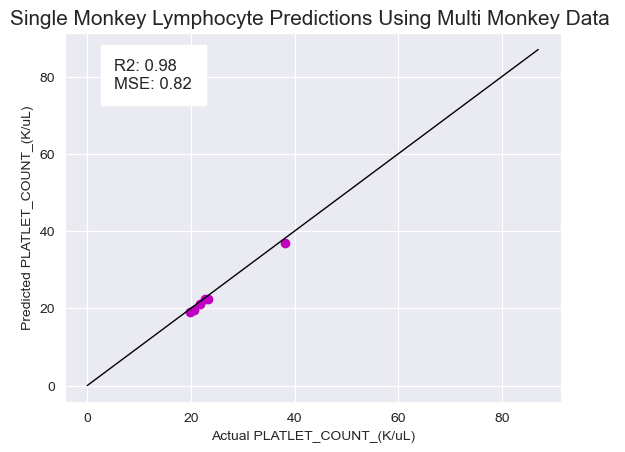

In [138]:
# Single Monkey Lymphocyte Predictions Using Multi Monkey Data 
xgb_predict_and_plot (model, sin_X_validation, sin_y_validation, y)

## Dose predictions

Target Feature Column: DOSE_(Gy)
Plot Title: Multi Monkey Dose (Gy) Predictions
Figure name xg-dose


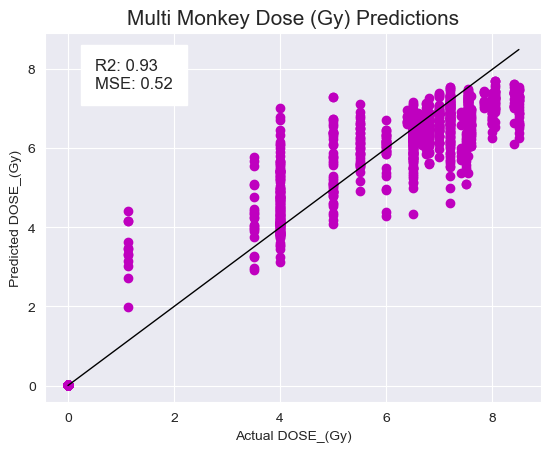

In [150]:
# Multi Monkey Dose (Gy)
xgb_pipeline(xg_df)

## Using top 5 features

In [91]:
# Single Monkey top 5 Features
sred_reg_df.tail(2)

,ID,Hemaglobin_(HGB_g/dL),NEUT_(%),ABS_LYMPH_(/uL),EOS_(%),RBC_(M/uL),LYMPHOCYTES_(%)
49,2046,14.1,36.9,5130,0.2,6.55,58.3
50,2046,12.3,45.9,3897,0.3,5.56,52.8


Target Feature Column: LYMPHOCYTES_(%)
Plot Title: Predicting Single Monkey Lymphocyte Using 5 Features
Figure name xgb-single-5


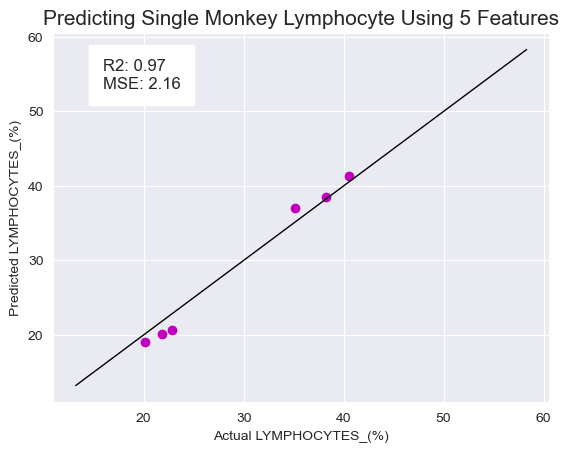

In [148]:
# Predicting Sinlge Monkey Lymphocyte Using the Top 5 Important Features
xgb_pipeline (sred_reg_df)

In [93]:
# Multi Monkey top 5 Features
mred_reg_df.tail(2)

,ID,ABS_MONO_(/uL),NEUT_(%),ABS_LYMPH_(/uL),EOS_(%),Hemaglobin_(HGB_g/dL),LYMPHOCYTES_(%)
4550,2210,632,51.2,2100,1.7,13.2,36.2
4551,2210,1176,60.0,896,3.0,13.2,16.0


Target Feature Column: LYMPHOCYTES_(%)
Plot Title: Predicting Single Monkey Lymphocyte Using 5 Features
Figure name xgb-multi-5


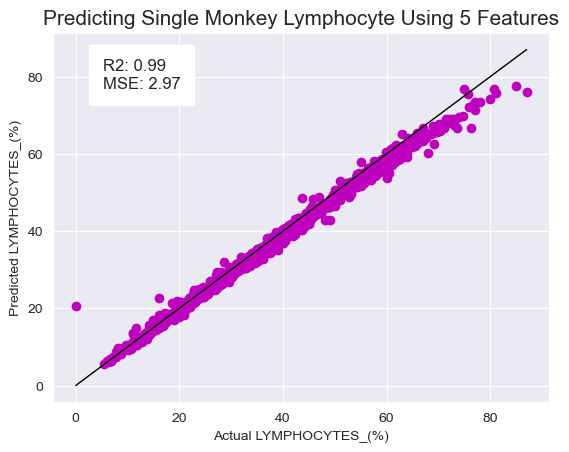

In [149]:
# Predicting Sinlge Monkey Lymphocyte Using the Top 5 Important Features
xgb_pipeline (mred_reg_df)

## Using Irrad data

In [95]:
# Multi monkey irrad only df
mrad_df.tail(2)

,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,LYMPHOCYTES_(%)
4550,2210,0,0,0.0,0.0,0.0,0.0,25.5,36.2
4551,2210,0,0,0.0,0.0,0.0,0.0,22.8,16.0


Target Feature Column: LYMPHOCYTES_(%)
Plot Title: Lymphocyte Predictions Using Radiation Data
Figure name xg-irrad-lymph


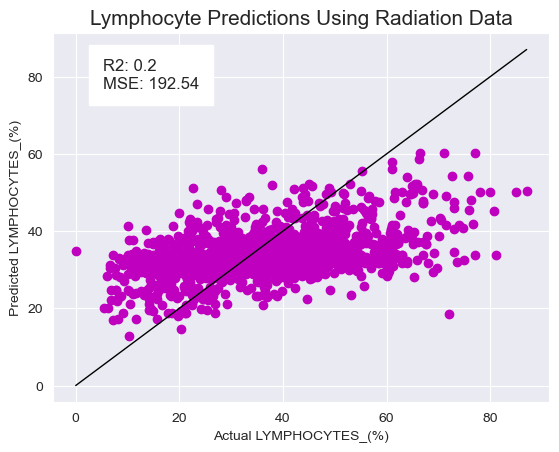

In [139]:
# Lymphocyte Predictions Using Radiation Data
xgb_pipeline (mrad_df)

## Classificationo of health data

In [157]:
# Make a df of the binary health data of the monkeys
minhealth_monkey_df = pd.read_excel('../Documents/demographic_data_r2.xlsx',
                    sheet_name=2,
                    skiprows = 0,
                    #usecols = ,
                    engine = 'openpyxl',
                    #date_parser=parser
                         )

minhealth_monkey_df['Animal_Status'] = minhealth_monkey_df['Animal_Status'].map({'LIVING':1, 'DECEASED': 0})
#minhealth_monkey_df.head(15)
minhealth_monkey_df.columns


Index(['ID', 'Time_Under_Observation_(yrs)', 'Dose_(Gy)', 'Irrad_Age_(months)',
       'Years_Since_Irrad', 'Current_Age_(years)', 'Animal_Status',
       'Diabetes_(Y/N)', 'Cataracts_(Y/N)', 'Arthritis_(Y/N)',
       'Periodontitis_(Y/N)', 'GI_(Y/N)', 'Behavior_(Y/N)', 'Tumor_(Y/N)',
       'Heart_(Y/N)', 'Hypertension_(Y/N)', 'Testicular Atrophy_(Y/N)',
       'Ovarian Dysfunction_(Y/N)', 'Hepatic_(Y/N)', 'Kidney_(Y/N)',
       'Lung_(Y/N)', 'Bone_(Y/N)', 'Overweight_(Y/N)', 'Underweight_(Y/N)',
       'Brain Lesion_(Y/N)'],
      dtype='object')

Target Feature Column: Tumor_(Y/N)
Figure name xgb-class-tumor


Accuracy: 0.8043478260869565 Precision: 0.5
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        37
           1       0.50      0.22      0.31         9

    accuracy                           0.80        46
   macro avg       0.67      0.58      0.60        46
weighted avg       0.77      0.80      0.77        46



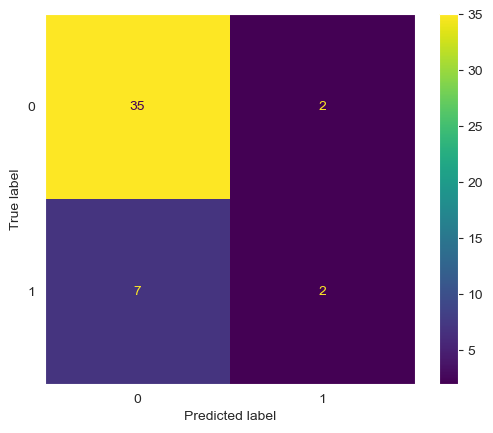

In [159]:
#whole data
xgb_classifier_pipeline (minhealth_monkey_df)

Target Feature Column: Tumor_(Y/N)
Figure name xgb_class-tumor-5


Accuracy: 0.8043478260869565 Precision: 0.5
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        37
           1       0.50      0.11      0.18         9

    accuracy                           0.80        46
   macro avg       0.66      0.54      0.54        46
weighted avg       0.76      0.80      0.75        46



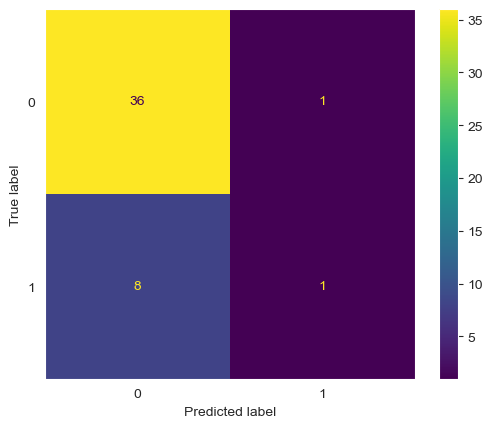

In [160]:
#make the 5 feature df
minhealth_monkey_df.copy()
five_health_df = minhealth_monkey_df[['ID', 'Dose_(Gy)', 'Heart_(Y/N)', 'Time_Under_Observation_(yrs)',
                                'Overweight_(Y/N)','Years_Since_Irrad', 'Tumor_(Y/N)']]

# classify with 5 features 
xgb_classifier_pipeline (five_health_df)

Target Feature Column: Tumor_(Y/N)
Figure name xgb_class-tumor-irrad


Accuracy: 0.782608695652174 Precision: 0.4
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        37
           1       0.40      0.22      0.29         9

    accuracy                           0.78        46
   macro avg       0.61      0.57      0.58        46
weighted avg       0.75      0.78      0.76        46



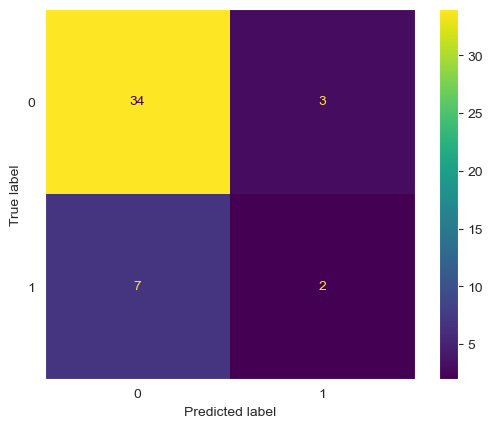

In [161]:
#make a parent df
minhealth_monkey_df.copy()
rad_health_df = minhealth_monkey_df[['ID', 'Dose_(Gy)', 'Irrad_Age_(months)',
                                           'Years_Since_Irrad', 'Current_Age_(years)', 'Tumor_(Y/N)']]

#irrad data
xgb_classifier_pipeline (rad_health_df)

# DL model - JAX
Jax: https://github.com/google/jax

- Jax uses transformers 
https://theaisummer.com/jax-transformer/

https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html

pytorch transformer: https://github.com/tunz/transformer-pytorch/blob/e7266679f0b32fd99135ea617213f986ceede056/model/transformer.py#L201


In [36]:
import jax
import jax.numpy as jnp
import haiku as hk
import numpy as np

In [43]:
class SelfAttention(hk.MultiHeadAttention):
    """Self attention with a causal mask applied."""

    def __call__(
            self,
            query: jnp.ndarray,
            key: Optional[jnp.ndarray] = None,
            value: Optional[jnp.ndarray] = None,
            mask: Optional[jnp.ndarray] = None,
    ) -> jnp.ndarray:
        key = key if key is not None else query
        value = value if value is not None else query

        seq_len = query.shape[1]
        causal_mask = np.tril(np.ones((seq_len, seq_len)))
        mask = mask * causal_mask if mask is not None else causal_mask

        return super().__call__(query, key, value, mask)

NameError: name 'Optional' is not defined

In [42]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import utils

# pylint: disable=arguments-differ


def initialize_weight(x):
    nn.init.xavier_uniform_(x.weight)
    if x.bias is not None:
        nn.init.constant_(x.bias, 0)


class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate):
        super(FeedForwardNetwork, self).__init__()

        self.layer1 = nn.Linear(hidden_size, filter_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(filter_size, hidden_size)

        initialize_weight(self.layer1)
        initialize_weight(self.layer2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, dropout_rate, head_size=8):
        super(MultiHeadAttention, self).__init__()

        self.head_size = head_size

        self.att_size = att_size = hidden_size // head_size
        self.scale = att_size ** -0.5

        self.linear_q = nn.Linear(hidden_size, head_size * att_size, bias=False)
        self.linear_k = nn.Linear(hidden_size, head_size * att_size, bias=False)
        self.linear_v = nn.Linear(hidden_size, head_size * att_size, bias=False)
        initialize_weight(self.linear_q)
        initialize_weight(self.linear_k)
        initialize_weight(self.linear_v)

        self.att_dropout = nn.Dropout(dropout_rate)

        self.output_layer = nn.Linear(head_size * att_size, hidden_size,
                                      bias=False)
        initialize_weight(self.output_layer)

    def forward(self, q, k, v, mask, cache=None):
        orig_q_size = q.size()

        d_k = self.att_size
        d_v = self.att_size
        batch_size = q.size(0)

        # head_i = Attention(Q(W^Q)_i, K(W^K)_i, V(W^V)_i)
        q = self.linear_q(q).view(batch_size, -1, self.head_size, d_k)
        if cache is not None and 'encdec_k' in cache:
            k, v = cache['encdec_k'], cache['encdec_v']
        else:
            k = self.linear_k(k).view(batch_size, -1, self.head_size, d_k)
            v = self.linear_v(v).view(batch_size, -1, self.head_size, d_v)

            if cache is not None:
                cache['encdec_k'], cache['encdec_v'] = k, v

        q = q.transpose(1, 2)                  # [b, h, q_len, d_k]
        v = v.transpose(1, 2)                  # [b, h, v_len, d_v]
        k = k.transpose(1, 2).transpose(2, 3)  # [b, h, d_k, k_len]

        # Scaled Dot-Product Attention.
        # Attention(Q, K, V) = softmax((QK^T)/sqrt(d_k))V
        q.mul_(self.scale)
        x = torch.matmul(q, k)  # [b, h, q_len, k_len]
        x.masked_fill_(mask.unsqueeze(1), -1e9)
        x = torch.softmax(x, dim=3)
        x = self.att_dropout(x)
        x = x.matmul(v)  # [b, h, q_len, attn]

        x = x.transpose(1, 2).contiguous()  # [b, q_len, h, attn]
        x = x.view(batch_size, -1, self.head_size * d_v)

        x = self.output_layer(x)

        assert x.size() == orig_q_size
        return x


class EncoderLayer(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate):
        super(EncoderLayer, self).__init__()

        self.self_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.self_attention = MultiHeadAttention(hidden_size, dropout_rate)
        self.self_attention_dropout = nn.Dropout(dropout_rate)

        self.ffn_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.ffn = FeedForwardNetwork(hidden_size, filter_size, dropout_rate)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):  # pylint: disable=arguments-differ
        y = self.self_attention_norm(x)
        y = self.self_attention(y, y, y, mask)
        y = self.self_attention_dropout(y)
        x = x + y

        y = self.ffn_norm(x)
        y = self.ffn(y)
        y = self.ffn_dropout(y)
        x = x + y
        return x


class DecoderLayer(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate):
        super(DecoderLayer, self).__init__()

        self.self_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.self_attention = MultiHeadAttention(hidden_size, dropout_rate)
        self.self_attention_dropout = nn.Dropout(dropout_rate)

        self.enc_dec_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.enc_dec_attention = MultiHeadAttention(hidden_size, dropout_rate)
        self.enc_dec_attention_dropout = nn.Dropout(dropout_rate)

        self.ffn_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.ffn = FeedForwardNetwork(hidden_size, filter_size, dropout_rate)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, enc_output, self_mask, i_mask, cache):
        y = self.self_attention_norm(x)
        y = self.self_attention(y, y, y, self_mask)
        y = self.self_attention_dropout(y)
        x = x + y

        if enc_output is not None:
            y = self.enc_dec_attention_norm(x)
            y = self.enc_dec_attention(y, enc_output, enc_output, i_mask,
                                       cache)
            y = self.enc_dec_attention_dropout(y)
            x = x + y

        y = self.ffn_norm(x)
        y = self.ffn(y)
        y = self.ffn_dropout(y)
        x = x + y
        return x


class Encoder(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate, n_layers):
        super(Encoder, self).__init__()

        encoders = [EncoderLayer(hidden_size, filter_size, dropout_rate)
                    for _ in range(n_layers)]
        self.layers = nn.ModuleList(encoders)

        self.last_norm = nn.LayerNorm(hidden_size, eps=1e-6)

    def forward(self, inputs, mask):
        encoder_output = inputs
        for enc_layer in self.layers:
            encoder_output = enc_layer(encoder_output, mask)
        return self.last_norm(encoder_output)


class Decoder(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate, n_layers):
        super(Decoder, self).__init__()

        decoders = [DecoderLayer(hidden_size, filter_size, dropout_rate)
                    for _ in range(n_layers)]
        self.layers = nn.ModuleList(decoders)

        self.last_norm = nn.LayerNorm(hidden_size, eps=1e-6)

    def forward(self, targets, enc_output, i_mask, t_self_mask, cache):
        decoder_output = targets
        for i, dec_layer in enumerate(self.layers):
            layer_cache = None
            if cache is not None:
                if i not in cache:
                    cache[i] = {}
                layer_cache = cache[i]
            decoder_output = dec_layer(decoder_output, enc_output,
                                       t_self_mask, i_mask, layer_cache)
        return self.last_norm(decoder_output)


class Transformer(nn.Module):
    def __init__(self, i_vocab_size, t_vocab_size,
                 n_layers=6,
                 hidden_size=512,
                 filter_size=2048,
                 dropout_rate=0.1,
                 share_target_embedding=True,
                 has_inputs=True,
                 src_pad_idx=None,
                 trg_pad_idx=None):
        super(Transformer, self).__init__()

        self.hidden_size = hidden_size
        self.emb_scale = hidden_size ** 0.5
        self.has_inputs = has_inputs
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

        self.t_vocab_embedding = nn.Embedding(t_vocab_size, hidden_size)
        nn.init.normal_(self.t_vocab_embedding.weight, mean=0,
                        std=hidden_size**-0.5)
        self.t_emb_dropout = nn.Dropout(dropout_rate)
        self.decoder = Decoder(hidden_size, filter_size,
                               dropout_rate, n_layers)

        if has_inputs:
            if not share_target_embedding:
                self.i_vocab_embedding = nn.Embedding(i_vocab_size,
                                                      hidden_size)
                nn.init.normal_(self.i_vocab_embedding.weight, mean=0,
                                std=hidden_size**-0.5)
            else:
                self.i_vocab_embedding = self.t_vocab_embedding

            self.i_emb_dropout = nn.Dropout(dropout_rate)

            self.encoder = Encoder(hidden_size, filter_size,
                                   dropout_rate, n_layers)

        # For positional encoding
        num_timescales = self.hidden_size // 2
        max_timescale = 10000.0
        min_timescale = 1.0
        log_timescale_increment = (
            math.log(float(max_timescale) / float(min_timescale)) /
            max(num_timescales - 1, 1))
        inv_timescales = min_timescale * torch.exp(
            torch.arange(num_timescales, dtype=torch.float32) *
            -log_timescale_increment)
        self.register_buffer('inv_timescales', inv_timescales)

    def forward(self, inputs, targets):
        enc_output, i_mask = None, None
        if self.has_inputs:
            i_mask = utils.create_pad_mask(inputs, self.src_pad_idx)
            enc_output = self.encode(inputs, i_mask)

        t_mask = utils.create_pad_mask(targets, self.trg_pad_idx)
        target_size = targets.size()[1]
        t_self_mask = utils.create_trg_self_mask(target_size,
                                                 device=targets.device)
        return self.decode(targets, enc_output, i_mask, t_self_mask, t_mask)

    def encode(self, inputs, i_mask):
        # Input embedding
        input_embedded = self.i_vocab_embedding(inputs)
        input_embedded.masked_fill_(i_mask.squeeze(1).unsqueeze(-1), 0)
        input_embedded *= self.emb_scale
        input_embedded += self.get_position_encoding(inputs)
        input_embedded = self.i_emb_dropout(input_embedded)

        return self.encoder(input_embedded, i_mask)

    def decode(self, targets, enc_output, i_mask, t_self_mask, t_mask,
               cache=None):
        # target embedding
        target_embedded = self.t_vocab_embedding(targets)
        target_embedded.masked_fill_(t_mask.squeeze(1).unsqueeze(-1), 0)

        # Shifting
        target_embedded = target_embedded[:, :-1]
        target_embedded = F.pad(target_embedded, (0, 0, 1, 0))

        target_embedded *= self.emb_scale
        target_embedded += self.get_position_encoding(targets)
        target_embedded = self.t_emb_dropout(target_embedded)

        # decoder
        decoder_output = self.decoder(target_embedded, enc_output, i_mask,
                                      t_self_mask, cache)
        # linear
        output = torch.matmul(decoder_output,
                              self.t_vocab_embedding.weight.transpose(0, 1))

        return output

    def get_position_encoding(self, x):
        max_length = x.size()[1]
        position = torch.arange(max_length, dtype=torch.float32,
                                device=x.device)
        scaled_time = position.unsqueeze(1) * self.inv_timescales.unsqueeze(0)
        signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)],
                           dim=1)
        signal = F.pad(signal, (0, 0, 0, self.hidden_size % 2))
        signal = signal.view(1, max_length, self.hidden_size)
        return signal


NameError: name '_C' is not defined